https://huggingface.co/docs/transformers/v4.42.0/ja/tasks/object_detection


In [1]:
from huggingface_hub import notebook_login
notebook_login()

In [2]:
import numpy as np
import os
from PIL import Image, ImageDraw

In [3]:
import datasets
# datsets.Featuresを定義
my_features = datasets.Features(
{ 'image': datasets.Image(mode=None, decode=True, id=None),
 'image_id': datasets.Value(dtype='int64', id=None),
 'width': datasets.Value(dtype='int32', id=None),
 'height': datasets.Value(dtype='int32', id=None),
 'objects': datasets.Sequence(feature={'id': datasets.Value(dtype='int64', id=None), 'area': datasets.Value(dtype='int64', id=None), 'bbox': datasets.Sequence(feature=datasets.Value(dtype='float32', id=None), length=4, id=None), 'category': datasets.ClassLabel(names=['zasou'], id=None)}, length=-1, id=None)})

In [4]:
from datasets import load_dataset
#dataset = load_dataset("imagefolder", data_dir="datasets")
dataset = load_dataset("imagefolder", data_dir="datasets", features=my_features)

Resolving data files:   0%|          | 0/124 [00:00<?, ?it/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'objects'],
        num_rows: 123
    })
})

In [6]:
dataset['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x427>,
 'image_id': 10,
 'width': 640,
 'height': 427,
 'objects': {'id': [88],
  'area': [208278],
  'bbox': [[23.0, 74.0, 609.0, 342.0]],
  'category': [0]}}

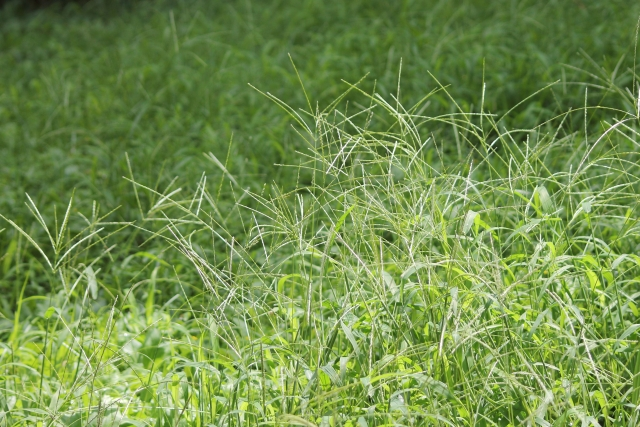

In [7]:
image=dataset['train'][0]["image"]
image

In [8]:
#id2label = {0: 'zasou'}
#label2id = {'zasou': 0}
categories = dataset["train"].features["objects"].feature["category"].names
id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}
id2label

{0: 'zasou'}

In [9]:
from transformers import AutoImageProcessor
checkpoint = "facebook/detr-resnet-50"
#checkpoint = "./detr-resnet-50_finetuned_zasou-2024.7.7-2"
#checkpoint = "./detr-resnet-50_finetuned_zasou-300epoch"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

画像の拡張

In [10]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

image_processor は、注釈が次の形式であることを期待します: {'image_id': int, 'annotations': List[Dict]},   
ここで、各辞書は COCO オブジェクトの注釈です。 1 つの例として、注釈を再フォーマットする関数を追加してみましょう。

In [11]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,     # int
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)
    return annotations

In [12]:
# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])
        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])
    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]
    return image_processor(images=images, annotations=targets, return_tensors="pt")


In [13]:
dataset['train'] = dataset['train'].with_transform(transform_aug_ann)
dataset['train'][15]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


{'pixel_values': tensor([[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2318,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [-1.3302, -1.3302, -1.3302,  ...,  1.2214,  1.2899,  1.3413],
          [-1.3473, -1.3473, -1.3473,  ...,  1.3927,  1.3755,  1.3755],
          [-1.3644, -1.3644, -1.3473,  ...,  1.4954,  1.4440,  1.4098]],
 
         [[ 2.0784,  2.0609,  2.0259,  ...,  2.0784,  2.0784,  2.0784],
          [ 2.0609,  2.0434,  2.0259,  ...,  2.0784,  2.0784,  2.0784],
          [ 2.0434,  2.0259,  2.0084,  ...,  2.0784,  2.0784,  2.0784],
          ...,
          [ 2.0084,  1.9734,  1.9034,  ...,  1.2906,  1.3081,  1.3081],
          [ 1.9909,  1.9559,  1.8859,  ...,  1.3957,  1.3256,  1.2906],
          [ 1.9909,  1.9559,  1.8859,  ...,  1.4657,  1.3431,  1.2731]],
 
         [[ 2.0474,  2.0300,  1.9951,  ...,  1.9777,  1.9777,  1.9777],
          [ 

In [14]:
import torch
from torchvision.ops import box_convert
from torchvision.utils import draw_bounding_boxes

from torchvision.transforms.functional import pil_to_tensor, to_pil_image
example = dataset['train'][15]

if False:
    to_pil_image(
        draw_bounding_boxes(
            #example["image"],
            example["pixel_values"],
            box_convert(example['bbox'], 'xywh', 'xyxy'),
            colors='red',
            #labels=[categories.int2str(x) for x in example['category']]
            labels=["zasou"]
        )
    )
#example
#dataset['train'][15]

In [15]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

Training the DETR model

In [16]:
#from transformers import DetrForObjectDetection
#model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
#model

In [17]:
from transformers import AutoModelForObjectDetection
model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)
#model

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (fc.weight, fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


learning_rate=1e-5  
300 epoch learning_rate=1.875e-8

In [18]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="detr-resnet-50_finetuned_zasou",
    per_device_train_batch_size=8,
    num_train_epochs=100,
    fp16=True,
    #warmup_steps=500,
    save_steps=200,
    logging_steps=50,
    learning_rate=1e-5,
    #learning_rate=1.875e-8,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
)

In [19]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=dataset["train"],
    tokenizer=image_processor,
)

trainer.train()

Step,Training Loss
50,0.213300
100,0.209300
150,0.206900
200,0.208400
250,0.206600
300,0.207200
350,0.213400
400,0.210400
450,0.211800
500,0.215400


TrainOutput(global_step=1600, training_loss=0.20787257373332976, metrics={'train_runtime': 2491.6142, 'train_samples_per_second': 4.937, 'train_steps_per_second': 0.642, 'total_flos': 5.876988680448e+18, 'train_loss': 0.20787257373332976, 'epoch': 100.0})

In [ ]:
trainer.push_to_hub()